# ハフ変換によるスケルトンの方向判定

- 微妙な凹凸は識別に関係ないので滑らかにする。
- サイズを正規化する
- スケルトン抽出してスケルトンの距離情報を作る。通常の距離は最短の黒画素までの距離として定義されるが、カバー率という概念を導入し、一定量（例えば９５％）の白画素が含まれる最大の距離を改めて距離と定義する。
- その距離範囲を白で塗りつぶした図形をあらためてシルエットとし、再度スケルトン抽出を行う。
- ハフ変換によりスケルトンの直線検出を行い、中心軸を定める。

これは１次近似。ベジエ曲線当てはめも試してみたい。

# 予備実験１

In [648]:
from skimage.morphology import skeletonize, skeletonize_3d
import matplotlib.pyplot as plt
from skimage.util import invert
from skimage import io
import skimage.data
import skimage.color
import os
import numpy as np
import cv2

def listimage(path='シルエット', needThum=False):

    directory = os.listdir(path)
    
    # まずフォルダを全部リストアップ　→ folders
    folders = []
    for x in os.listdir(path):  
        if os.path.isdir(path + '/'+x) and x[0] != '.' and x[0] !='_':  #パスに取り出したオブジェクトを足してフルパスに
            folders.append(path + '/'+x)
    # print(folders)

    # folders の各フォルダの中にある jpg ファイルをリストアップ → ffiles
    # ffiles はフォルダごとのリストのリスト
    ffiles = []
    for x in folders:
        files = []
        for f in os.listdir(x):
            entry = x + '/'+f
            if os.path.isfile(entry) and f[-4:]=='.jpg' and f[0] != '.':
                files.append(entry)
        ffiles.append(files)
    
    if needThum: # サムネイルの作成
        i = 0
        for cat in ffiles:
            # print(folders[i])
            sam = Image.new('RGB', (800,600),(0,0,0))
            row = col = 0
            for rad in cat:
                img = Image.open(rad, 'r')
                thumbnail_size = (100, 100)
                img.thumbnail(thumbnail_size)
                sam.paste(img,(col,row))
                col += 100
                if col == 800:
                    col = 0
                    row += 100
                # plt.imshow(sam)
            sam.save('{}THUM.png'.format(folders[i]), 'PNG')
            print("saved {}".format(folders[i]))
            i +=1

    return folders,ffiles

# マージンをつける
def makemargin(img,mr=2):
    h,w = img.shape[:2]
    w2 = mr*w
    h2 = mr*h
    x1 = int((w2-w)/2)
    y1 = int((h2-h)/2)
    img2 = np.zeros((h2,w2),np.uint8)
    img2[y1:y1+h,x1:x1+w] = img
    return img2

# ２枚の画像をサイズを並べた画像を作成する
def mkparaimage(img1,img2):
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    if img1.ndim == 2:
        img11 = np.zeros((h1,w1,3))
        img11[:,:,0]=img11[:,:,1]=img11[:,:,2]=img1
    else:
        img11=img1
    if img2.ndim == 2:
        img22 = np.zeros((h2,w2,3))
        img22[:,:,0]=img22[:,:,1]=img22[:,:,2]=img2
    else:
        img22=img2
    paraimg = 255*np.ones((max(h1,h2),w1+w2+10,3),dtype=np.uint8)
    
    paraimg[0:h1,0:w1,:] = img11
    paraimg[0:h2,w1+10:,:]=img22
    
    return paraimg

# mkparaimage で２枚並べた画像を表示
def imshowpara(img1,img2):
    plotimg(mkparaimage(img1,img2))

# 近傍画素の取り出し
def get8n(img,x,y):
    ret =  [img[y][x+1],img[y-1][x+1],img[y-1][x],img[y-1][x-1], \
            img[y][x-1],img[y+1][x-1],img[y+1][x],img[y+1][x+1], \
            img[y][x+1],img[y-1][x+1],img[y][x]]
    return ret

# 連結数の計算（８連結）
def getCN(img,x,y):
    nb = get8n(img,x,y 
    for i in range(0,8,2):
        ret += (1-nb[i]) - (1-nb[i])*(1-nb[i+1])*(1-nb[i+2])
    return ret

# 処理結果画像（fimg)に処理前画像（bimg)の輪郭を描く
def draw2(bimg,fimg):
    if len(bimg.shape)==3:
        bimg2 = cv2.cvtColor(bimg,cv2.COLOR_BGR2GRAY)
    else:
        bimg2 = bimg.copy()
    if len(fimg.shape)==3:
        fimg2 = fimg.copy()
    else:
        fimg2 = cv2.cvtColor(fimg,cv2.COLOR_GRAY2BGR)
    # 処理前画像の輪郭
    canvas = np.zeros_like(fimg2)
    _ret,bwimg = cv2.threshold(bimg2,128,255,cv2.THRESH_BINARY) # 白画素は255にする
    _img,cnt,hierarchy = cv2.findContours(bwimg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    canvas = cv2.drawContours(canvas, cnt, -1, (255,230,230), thickness=-1)
    
    return cv2.addWeighted(fimg2, 0.5, canvas, 0.5,0)
                  
    # return retimg[:,:,::-1] # opencv -> PIL


In [925]:
###### UNIT = 256
# https://www.piskelapp.com/p/agxzfnBpc2tlbC1hcHByEwsSBlBpc2tlbBiAgKDQzJChCQw/edit

CONTOURS_APPROX = 0.005 # 輪郭近似精度
SHRINK = 0.67 # 収縮膨張で形状を整える時のパラメータ
GAUSSIAN_RATE = 0.3 # ガウスぼかしをかける程度

# 形の整形ステップ１
def getskeleton(path):
    print(path)
    src = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    img2 = makemargin(src) # 作業用のマージンを確保
    refimg = img2.copy() # 参照画像
    
    # ガウスぼかしを適用してシルエットを滑らかにする
    ksize = int(GAUSSIAN_RATE*src.shape[1]/2)*2+1 # ぼかし量  元の図形の幅に応じて決める
    img2 = cv2.GaussianBlur(img2,(ksize,ksize),0) # ガウスぼかしを適用
    _ret,img2 = cv2.threshold(img2, 127, 255, cv2.THRESH_BINARY) # ２値化
    
    # 収縮・膨張によりヒゲ根を除去する
    area0 = np.sum(img2) # img2 の画素数*255 になるはず
    kernel = np.ones((3,3),np.uint8) 
    tmpimg = cv2.erode(img2,kernel,iterations = 1) # 収縮１回目
    area1 = np.sum(tmpimg) # 収縮したので area0 より少なくなる
    n = 1
    while area1  > SHRINK*area0: # 面積が 3/4 以下になるまで繰り返す
        tmpimg = cv2.erode(tmpimg,kernel,iterations = 1)
        area1 = np.sum(tmpimg) 
        n += 1
    # print("収縮・膨張回数",n)
    img3 = cv2.dilate(tmpimg,kernel,iterations = n) # 同じ回数膨張させる

    # 楕円近似で軸方向を求める
    # あらためて輪郭を求め直す
    _img,cnt,hierarchy = cv2.findContours(img3, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) #  あらためて輪郭を抽出
    
    # 輪郭の近似を使って形状を整える。同時に円形度を計算しておく。
    
    area = cv2.contourArea(cnt[0]) # 面積
    perimeter = cv2.arcLength(cnt[0],True) # 周囲長
    epsilon = CONTOURS_APPROX*perimeter
    '''
    approx = cv2.approxPolyDP(cnt[0],epsilon,True)
    
    workimg = np.zeros_like(img3,np.uint8)
    workimg = cv2.drawContours(workimg, [approx], 0, 255, thickness=-1) 
    img3 = workimg.copy()
    #　再び輪郭を求め直す
    # _img,cnt,hierarchy = cv2.findContours(img3, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) #  あらためて輪郭を抽出
    
    rect1 = cv2.fitEllipse(approx) # 楕円近似する
    '''
    rect1 = cv2.fitEllipse(cnt[0]) # 楕円近似する

    box = np.int0(cv2.boxPoints(rect1))  # (対角点1,幅と高さ,回転角) から４点座標に変換
    # 回転角と中心
    deg = rect1[2]
    while deg > 45:
        deg -= 90 
    x0,y0 = rect1[0]     
    
    # 非常に稀であるが、回転すると全体が描画領域外に出ることがあるので作業領域を広く確保
    # mat = cv2.getRotationMatrix2D((x0,y0), deg, 1.0) # アフィン変換マトリクス
    img4 = makemargin(img3,mr=2) # 作業用のマージンを確保
    refimg = makemargin(refimg,mr=2) # 参照画像
    h3,w3 = img3.shape[:2]
    h4,w4 = img4.shape[:2]
    mat = cv2.getRotationMatrix2D((x0+(w4-w3)/2,y0+(h4-h3)/2), deg, 1.0) # アフィン変換マトリクス

    # アフィン変換の適用
    img4 = cv2.warpAffine(img4, mat, (0,0))
    refimg = cv2.warpAffine(refimg, mat, (0,0))

    # 再び最小矩形を求めて切り出す。
    _nLabels, _labelImages, data, _center = cv2.connectedComponentsWithStats(img4) 
    img4 = img4[data[1][1]:data[1][1]+data[1][3],data[1][0]:data[1][0]+data[1][2]]
    refimg = refimg[data[1][1]:data[1][1]+data[1][3],data[1][0]:data[1][0]+data[1][2]]
    
    '''
    # 長辺が UNIT ピクセルになるよう縮小し、(２xUNIT)x(2xUNIT)の画像の中央に配置する。
    h,w = img4.shape[:2]
    u_l = w if w > h else h
    s_r = UNIT/w if w > h else UNIT/h
    
    # rsh,rsw = int(s_r*h),int(s_r*w)
    # 縦は２倍に引きのばしてみる
    rsh,rsw = int(s_r*h),int(s_r*w)
    
    x0 = int((2*UNIT-rsw)/2)
    y0 = int((2*UNIT-rsh)/2)
    img5 = np.zeros((2*UNIT,2*UNIT),np.uint8)
    img4 = cv2.resize(img4,(rsw,rsh))
    img5[y0:y0+rsh,x0:x0+rsw] = img4
    
    refimg2 = np.zeros((2*UNIT,2*UNIT),np.uint8)
    refimg = cv2.resize(refimg,(rsw,rsh))
    refimg2[y0:y0+rsh,x0:x0+rsw] = refimg

    # 細かい凹凸を無くしたいので少しだけぼかして２値化
    blurimg = cv2.GaussianBlur(img5,(ksize,ksize),0) 
    ret,thimg = cv2.threshold(blurimg,128,1,cv2.THRESH_BINARY) # 白画素は１にする        
    #  1ピクセル幅の部分は厄介なので、１回だけ膨張させて幅１の部分は無くす
    # dilateimg = cv2.dilate(thimg,(3,3),iterations = 1)
    dilateimg = thimg #  
    
    # 孔が生じる可能性があるので、念のため、最外殻輪郭を取り出し、描きなおすことで孔を無くす
    _img,cnt,hierarchy = cv2.findContours(dilateimg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img2 = cv2.drawContours(dilateimg, cnt, 0, 255, thickness=-1)
    ret,thimg2 = cv2.threshold(img2,127,1,cv2.THRESH_BINARY)
    
    # 細線化
    skeleton = skeletonize(thimg2)

    # マージンを上下左右８ピクセルとる。Y
    x0,y0 = int(UNIT/2)-8,int(UNIT/2)-8
    x1,y1 = int(UNIT+UNIT/2)+8,int(UNIT+UNIT/2)+8
    '''
    # 長辺が UNIT ピクセルになるよう縮小し、(２xUNIT)x(３xUNIT)の画像の中央に配置する。
    h,w = img4.shape[:2]
    u_l = w if w > h else h
    s_r = UNIT/w if w > h else UNIT/h
    
    # rsh,rsw = int(s_r*h),int(s_r*w)
    # 縦は２倍に引きのばしてみる
    rsh,rsw = int(2*s_r*h),int(s_r*w)
    
    x0 = int((2*UNIT-rsw)/2)
    y0 = int((3*UNIT-rsh)/2)
    img5 = np.zeros((3*UNIT,2*UNIT),np.uint8)
    img4 = cv2.resize(img4,(rsw,rsh))
    img5[y0:y0+rsh,x0:x0+rsw] = img4
    
    refimg2 = np.zeros((3*UNIT,2*UNIT),np.uint8)
    refimg = cv2.resize(refimg,(rsw,rsh))
    refimg2[y0:y0+rsh,x0:x0+rsw] = refimg
    
    # 細かい凹凸を無くしたいので少しだけぼかして２値化
    blurimg = cv2.GaussianBlur(img5,(ksize,ksize),0) 
    ret,thimg = cv2.threshold(blurimg,128,1,cv2.THRESH_BINARY) # 白画素は１にする        
    #  1ピクセル幅の部分は厄介なので、１回だけ膨張させて幅１の部分は無くす
    # dilateimg = cv2.dilate(thimg,(3,3),iterations = 1)
    dilateimg = thimg #  
    
    # 孔が生じる可能性があるので、念のため、最外殻輪郭を取り出し、描きなおすことで孔を無くす
    _img,cnt,hierarchy = cv2.findContours(dilateimg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img2 = cv2.drawContours(dilateimg, cnt, 0, 255, thickness=-1)
    ret,thimg2 = cv2.threshold(img2,127,1,cv2.THRESH_BINARY)
    
    # 細線化
    skeleton = skeletonize(thimg2)

    # マージンを上下左右８ピクセルとる。Y方向はあとで二分の１に縮小するので、１６ピクセル
    x0,y0 = int(UNIT/2)-8,int(UNIT/2)-16
    x1,y1 = int(UNIT+UNIT/2)+8,int(2*UNIT+UNIT/2)+16
    
    skeleton = cv2.resize(np.array(skeleton[y0:y1,x0:x1],np.uint8),(UNIT+16,UNIT+16))
    skeleton = skeletonize(skeleton) # リサイズしたので再度処理しなおす
    outimg = cv2.resize(thimg2[y0:y1,x0:x1],(UNIT+16,UNIT+16)) 
    refimg2 = cv2.resize(refimg2[y0:y1,x0:x1],(UNIT+16,UNIT+16))

    # 連結数２以外の点の取り出し
    skimg = 255*skeleton.astype(np.uint8)
    color = cv2.cvtColor(skimg,cv2.COLOR_GRAY2BGR)

    for j in range(skeleton.shape[0]-1):
        for i in range(skeleton.shape[1]-1):
            if skeleton[j][i] :
                cn = getCN(skeleton,i,j)
                if cn != 2:
                    cv2.circle(color,(i,j),5,(255,255,0),-1)
                    if cn !=1 : # 端点以外は取り除く
                        skeleton[j][i] = False
    
    #  分岐点を取り除いたのち、最大のセグメントを抜き出す。
    skimg = 255*skeleton.astype(np.uint8)
    nLabels, labelImages, data, _center = cv2.connectedComponentsWithStats(skimg) 
    # 面積最大のセグメント番号　→ max_index
    max_index = np.argmax(data[1:,4])  # 先頭は背景なので除外して１番以降で面積（４）が最大のインデックス
    # その番号のラベルがついている画素かどうかの２次元配列
    maxseg = (labelImages == max_index+1) # 上で１番はインデックス０番目なので１加える
    # ハフ変換     
    rho,theta = getAxis(maxseg)
    '''
    if rho == 0 and theta == 0:
        print("ERROR")
    else :
        print("rho,theta=",rho,theta)'''
    return refimg2,outimg,color,skeleton,rho,theta

def getline(rho,theta):
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        return x1,y1,x2,y2

# ハフ変換による直線近似
def getAxis(skeleton):
    points = 255*skeleton.astype(np.uint8)
    color = cv2.cvtColor(points,cv2.COLOR_GRAY2BGR)
    # ハフ変換
    rho,thea = 0,0
    lines = cv2.HoughLines(points,threshold=10,theta=np.pi/180,rho=1,srn=0,stn=0)    
    '''for line  in lines[3:5]:
        for [rho,theta] in line:
            x1,y1,x2,y2 = getline(rho,theta)
            cv2.line(color,(x1,y1),(x2,y2),(0,255,0),1)
    for line  in lines[0:3]:
        for [rho,theta] in line:
            x1,y1,x2,y2 = getline(rho,theta)
            cv2.line(color,(x1,y1),(x2,y2),(255,255,0),1)
    plt.imshow(color)'''
    [rho,theta] = lines[0][0] # １番のみ取り出す
    return rho,theta

In [926]:
def batch(images, savedir='概形シルエット3',interactive = True):
    # savedir 保存先
    # interactive 結果を１枚ずつ確認するかどうか
    
    for path in images:
        refimg2,outimg,color, skeleton,rho,theta = getskeleton(path)
        
        # 回転角と中心
        deg = theta
        ''' while deg > 45:
            deg -= 90 
        x0,y0 = 0,0     '''
    
        # 非常に稀であるが、回転すると全体が描画領域外に出ることがあるので作業領域を広く確保
        # mat = cv2.getRotationMatrix2D((x0,y0), deg, 1.0) # アフィン変換マトリクス
        img4 = makemargin((255*outimg).astype(np.uint8),mr=2) # 作業用のマージンを確保
        h3,w3 = outimg.shape[:2]
        h4,w4 = img4.shape[:2]
        mat = cv2.getRotationMatrix2D(((w4-w3)/2,(h4-h3)/2), -deg, 1.0) # アフィン変換マトリクス

        # アフィン変換の適用
        img4 = cv2.warpAffine(img4, mat, (0,0))    
    
        if interactive:
            x1,y1,x2,y2 = getline(rho,theta)
            
            cv2.imshow(path,img4)
            # cv2.imshow("New",color)
            key = cv2.waitKey(0)
            cv2.destroyAllWindows()
            cv2.waitKey(1) 
            if key == 113: #  "Q" で終了する
                break

_dir,ffiles = listimage(path='シルエット', needThum=False) 
batch(sum(ffiles,[]), savedir='概形シルエット3',interactive = True)


# src, outimg, color, skeleton = go('シルエット/17Tran_ellip/17heians1o07_l.jpg')

シルエット/17Cylindric/17daruma2o05_l.jpg
シルエット/17Cylindric/17daruma3o01_l.jpg
シルエット/17Cylindric/17daruma3o02_l.jpg
シルエット/17Cylindric/17daruma3o03_l.jpg
シルエット/17Cylindric/17daruma3o05_l.jpg
シルエット/17Cylindric/17daruma3o09_l.jpg
シルエット/17Cylindric/17daruma6o09_l.jpg
シルエット/17Cylindric/17kohaku1o02_l.jpg
シルエット/17Cylindric/17kohaku1o09_l.jpg
シルエット/17Cylindric/17kohaku2o10_l.jpg
シルエット/17Cylindric/17makoto1o01_l.jpg
シルエット/17Cylindric/17makoto1o05_l.jpg
シルエット/17Cylindric/17makoto1o06_l.jpg
シルエット/17Cylindric/17makoto1o10_l.jpg
シルエット/17Cylindric/17makoto2o03_l.jpg
シルエット/17Cylindric/17makoto2o06_l.jpg
シルエット/17Cylindric/17santar2o09_l.jpg
シルエット/17Cylindric/17santar2o10_l.jpg
シルエット/17Cylindric/17sinsyt1o08_l.jpg
シルエット/17Cylindric/17tanabe1o01_l.jpg
シルエット/17Cylindric/17tanabe1o02_l.jpg
シルエット/17Cylindric/17tanabe1o05_l.jpg
シルエット/17Cylindric/17tanabe1o06_l.jpg
シルエット/17Cylindric/17tanabe1o07_l.jpg
シルエット/17Cylindric/17tanabe1o09_l.jpg


In [911]:
np.max(outimg)

1

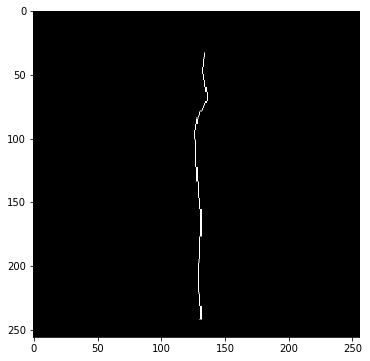

In [530]:
# 近傍画素の取り出し
def get8n(img,x,y):
    ret =  [img[y][x+1],img[y-1][x+1],img[y-1][x],img[y-1][x-1], \
            img[y][x-1],img[y+1][x-1],img[y+1][x],img[y+1][x+1], \
            img[y][x+1],img[y-1][x+1],img[y][x]]
    return ret

# 連結数の計算（８連結）
def getCN(img,x,y):
    nb = get8n(img,x,y)
    ret = 0
    for i in range(0,8,2):
        ret += (1-nb[i]) - (1-nb[i])*(1-nb[i+1])*(1-nb[i+2])
    return ret

# 連結数２以外の点の取り出し
testskel = 1*np.array(skeleton,np.uint8)
color = cv2.cvtColor(testskel,cv2.COLOR_GRAY2BGR)
for j in range(testskel.shape[0]):
    for i in range(testskel.shape[1]):
        if testskel[j][i] == 1 and getCN(testskel,i,j) != 2:
            print("found",i,j,getCN(testskel,i,j),get8n(testskel,i,j))
            cv2.circle(color,(i,j),10,(255,255,0),-1)
# plt.imshow(testskel)
plt.imshow(color)

シルエット/17Apically/17daruma6o06_l.jpg
(256, 256) (256, 256)


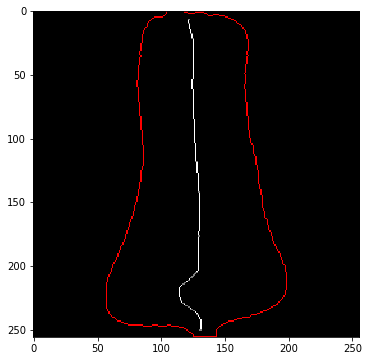

In [531]:
src, thimg2, skeleton = go('シルエット/17Apically/17daruma6o06_l.jpg')

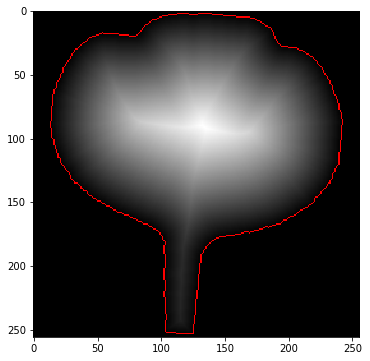

In [475]:
from PIL import ImageDraw,Image
from pylab import rcParams
rcParams['figure.figsize'] = 8,6

# 処理結果画像（fimg)に処理前画像（bimg)の輪郭を描く
def draw2(bimg,fimg):
    if len(bimg.shape)==3:
        bimg2 = cv2.cvtColor(bimg,cv2.COLOR_BGR2GRAY)
    else:
        bimg2 = bimg.copy()
    if len(fimg.shape)==3:
        fimg2 = fimg.copy()
    else:
        fimg2 = cv2.cvtColor(fimg,cv2.COLOR_GRAY2BGR)
    # 処理前画像の輪郭
    _ret,bwimg = cv2.threshold(bimg2,128,255,cv2.THRESH_BINARY) # 白画素は255にする
    _img,cnt,hierarchy = cv2.findContours(bwimg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    retimg = cv2.drawContours(fimg2, cnt, 0, (0,0,255), thickness=1)
    return retimg[:,:,::-1] # opencv -> PIL

dst = cv2.distanceTransform(thimg2,cv2.DIST_L2,5)
dstmax = np.max(dst)
dst = (255*dst/dstmax).astype(np.uint8)
img = draw2(src,dst)

'''
cv2.imshow("S",img)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1) '''

plt.imshow(img)
plt.show()

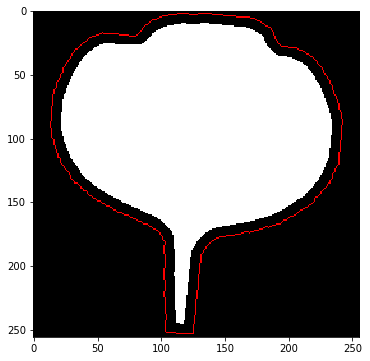

In [479]:
th = 1*np.max(dst)/10 # 最大距離の1/10を閾値に設定してみる
_ret,dstth = cv2.threshold(dst,th,255,cv2.THRESH_BINARY)
img = draw2(src,dstth)
plt.imshow(img)

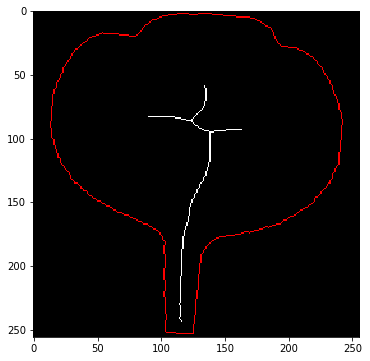

In [480]:
# 細線化してみる
ret,dstth2 = cv2.threshold(dstth,128,1,cv2.THRESH_BINARY)
skeleton = (255*skeletonize(dstth2)).astype(np.uint8)
img = draw2(src,skeleton)
plt.imshow(img)

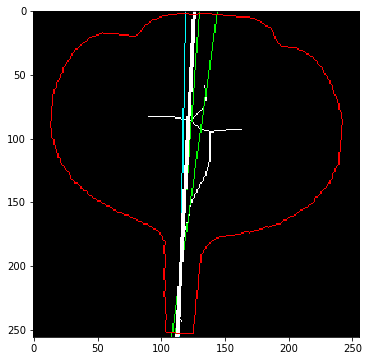

In [484]:
gray = skeleton.copy()
color = cv2.cvtColor(gray,cv2.COLOR_GRAY2BGR)

# edges = cv2.Canny(rsskel2,50,150,apertureSize = 3)
# ハフ変換
lines = cv2.HoughLines(gray,threshold=10,theta=np.pi/180,rho=1,srn=0,stn=0)

for line  in lines[3:5]:
    for [rho,theta] in line:
        x1,y1,x2,y2 = getline(rho,theta)
        cv2.line(color,(x1,y1),(x2,y2),(0,255,0),1)
for line  in lines[1:3]:
    for [rho,theta] in line:
        x1,y1,x2,y2 = getline(rho,theta)
        cv2.line(color,(x1,y1),(x2,y2),(255,255,0),1)
[rho,theta] = line[0]
x1,y1,x2,y2 = getline(rho,theta)
cv2.line(color,(x1,y1),(x2,y2),(255,255,255),2)
'''        
for [rho,theta] in lines[0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(color,(x1,y1),(x2,y2),(0,255,0),1)
'''
img = draw2(src,color)
plt.imshow(img)

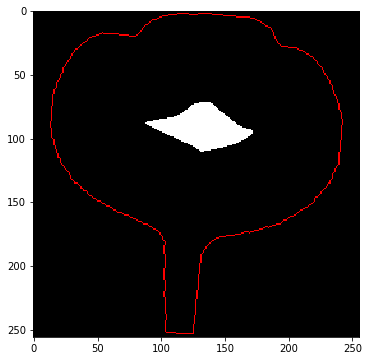

In [485]:
th = 8*np.max(dst)/10 # 最大距離の半分を閾値に設定してみる
_ret,dstth = cv2.threshold(dst,th,255,cv2.THRESH_BINARY)
img = draw2(src,dstth)
plt.imshow(img)

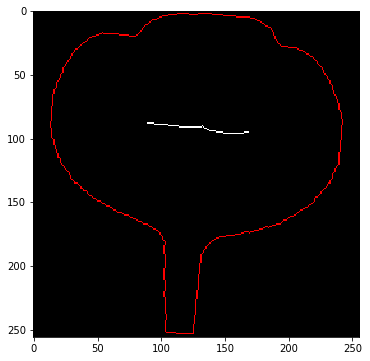

In [487]:
# 細線化してみる
ret,dstth2 = cv2.threshold(dstth,128,1,cv2.THRESH_BINARY)
skeleton = (255*skeletonize(dstth2)).astype(np.uint8)
img = draw2(src,skeleton)
plt.imshow(img)

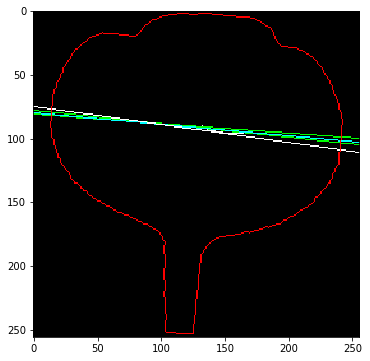

In [488]:
gray = skeleton.copy()
color = cv2.cvtColor(gray,cv2.COLOR_GRAY2BGR)

# edges = cv2.Canny(rsskel2,50,150,apertureSize = 3)
# ハフ変換
lines = cv2.HoughLines(gray,threshold=12,theta=np.pi/180,rho=1,srn=0,stn=0)

def getline(rho,theta):
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        return x1,y1,x2,y2

for line  in lines[3:5]:
    for [rho,theta] in line:
        x1,y1,x2,y2 = getline(rho,theta)
        cv2.line(color,(x1,y1),(x2,y2),(0,255,0),1)
for line  in lines[1:3]:
    for [rho,theta] in line:
        x1,y1,x2,y2 = getline(rho,theta)
        cv2.line(color,(x1,y1),(x2,y2),(255,255,0),1)
[rho,theta] = line[0]
x1,y1,x2,y2 = getline(rho,theta)
cv2.line(color,(x1,y1),(x2,y2),(255,255,255),1)

'''        
for [rho,theta] in lines[0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(color,(x1,y1),(x2,y2),(0,255,0),1)
'''
img = draw2(src,color)
plt.imshow(img)

シルエット/17Tran_ellip/17heians1o07_l.jpg
(223, 133)


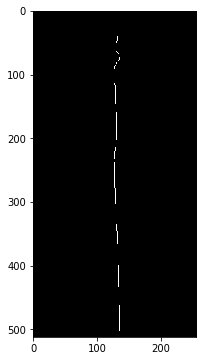

In [490]:
# もし縦に２倍に引き伸ばしてやるとどうなるか

UNIT = 256
# https://www.piskelapp.com/p/agxzfnBpc2tlbC1hcHByEwsSBlBpc2tlbBiAgKDQzJChCQw/edit

# 形の整形ステップ１
def go(imgfilename):
    print(imgfilename)
    src = cv2.imread(imgfilename,0)
    # 長辺が 2UNIT ピクセル、短編はUNITピクセルになるよう縮小し、(2xUNIT)x(2xUNIT)の画像の中央に配置する。
    print(src.shape)
    h,w = src.shape[:2]
    u_l = w if w > h else h
    s_r = UNIT/w if w > h else UNIT/h
    rsh,rsw = int(2*s_r*h),int(s_r*w)
    x0 = int((2*UNIT-rsw)/2)
    y0 = int((2*UNIT-rsh)/2)
    img = np.zeros((2*UNIT,2*UNIT),np.uint8)
    img[y0:y0+rsh,x0:x0+rsw] = cv2.resize(src,(rsw,rsh))

    # 細かい凹凸を無くしたいので少しだけぼかして２値化
    blurimg = cv2.GaussianBlur(img,(15,15),0) 
    ret,thimg = cv2.threshold(blurimg,128,1,cv2.THRESH_BINARY) # 白画素は１にする        
    #  1ピクセル幅の部分は厄介なので、１回だけ膨張させて幅１の部分は無くす
    # dilateimg = cv2.dilate(thimg,(3,3),iterations = 1)
    dilateimg = thimg #  
    # 孔が生じる可能性があるので、念のため、最外殻輪郭を取り出し、描きなおすことで孔を無くす
    _img,cnt,hierarchy = cv2.findContours(dilateimg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img2 = cv2.drawContours(dilateimg, cnt, 0, 255, thickness=-1)
    ret,thimg2 = cv2.threshold(img2,127,1,cv2.THRESH_BINARY)
    skeleton = skeletonize(thimg2)
    # 結果を出力します
    # x0,y0 = int(UNIT/2),int(UNIT/2)
    # x1,y1 = int(2*UNIT-UNIT/2),int(2*UNIT-UNIT/2)
    x0,y0 = int(UNIT/2),0
    x1,y1 = int(2*UNIT-UNIT/2),int(2*UNIT)
    plt.imshow(skeleton[y0:y1,x0:x1], cmap='gray')
    plt.show()

    return img[y0:y1,x0:x1],thimg2[y0:y1,x0:x1],skeleton[y0:y1,x0:x1]

src, thimg2, skeleton = go('シルエット/17Tran_ellip/17heians1o07_l.jpg')

シルエット/17Tran_ellip/17heians1o07_l.jpg
(223, 133)


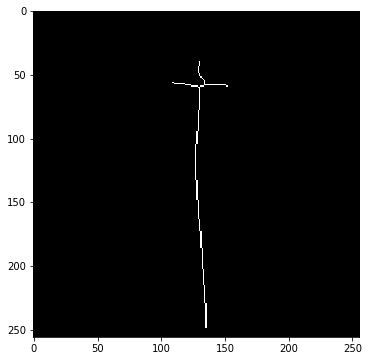

In [491]:
UNIT = 256

# 形の整形ステップ１
def go(imgfilename):
    print(imgfilename)
    src = cv2.imread(imgfilename,0)
    # 長辺が UNIT ピクセルになるよう縮小し、(2xUNIT)x(2xUNIT)の画像の中央に配置する。
    print(src.shape)
    h,w = src.shape[:2]
    u_l = w if w > h else h
    s_r = UNIT/w if w > h else UNIT/h
    rsh,rsw = int(s_r*h),int(s_r*w)
    x0 = int((2*UNIT-rsw)/2)
    y0 = int((2*UNIT-rsh)/2)
    img = np.zeros((2*UNIT,2*UNIT),np.uint8)
    img[y0:y0+rsh,x0:x0+rsw] = cv2.resize(src,(rsw,rsh))

    # 細かい凹凸を無くしたいので少しだけぼかして２値化
    blurimg = cv2.GaussianBlur(img,(15,15),0) 
    ret,thimg = cv2.threshold(blurimg,128,1,cv2.THRESH_BINARY) # 白画素は１にする        
    #  1ピクセル幅の部分は厄介なので、１回だけ膨張させて幅１の部分は無くす
    # dilateimg = cv2.dilate(thimg,(3,3),iterations = 1)
    dilateimg = thimg #  
    # 孔が生じる可能性があるので、念のため、最外殻輪郭を取り出し、描きなおすことで孔を無くす
    _img,cnt,hierarchy = cv2.findContours(dilateimg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img2 = cv2.drawContours(dilateimg, cnt, 0, 255, thickness=-1)
    ret,thimg2 = cv2.threshold(img2,127,1,cv2.THRESH_BINARY)
    skeleton = skeletonize(thimg2)
    # 結果を出力します
    x0,y0 = int(UNIT/2),int(UNIT/2)
    x1,y1 = int(2*UNIT-UNIT/2),int(2*UNIT-UNIT/2)
    plt.imshow(skeleton[y0:y1,x0:x1], cmap='gray')
    plt.show()

    return thimg2,skeleton

thimg2, skeleton = go('シルエット/17Tran_ellip/17heians1o07_l.jpg')

# 二次ベジエ曲線によるスケルトン近似


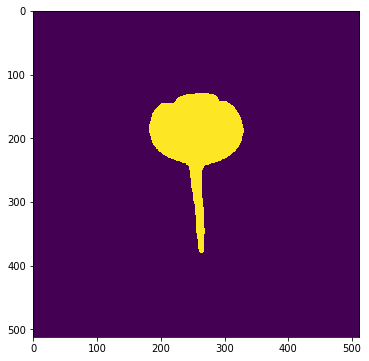

In [492]:
plt.imshow(thimg2)

In [493]:
# 
def get8n(img,x,y):
    ret =  [img[y][x+1],img[y-1][x+1],img[y-1][x],img[y-1][x-1], \
            img[y][x-1],img[y+1][x-1],img[y+1][x],img[y+1][x+1], \
            img[y][x+1],img[y-1][x+1],img[y][x]]
    return ret

def getCN(img,x,y):
    nb = get8n(img,x,y)
    ret = 0
    for i in range(0,8,2):
        ret += (1-nb[i]) - (1-nb[i])*(1-nb[i+1])*(1-nb[i+2])
    return ret

In [494]:
# testskel = 1*np.array(skeleton,np.uint8)
print(np.max(testskel))

1


found 258 168 1 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
found 237 184 1 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]
found 280 187 1 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]
found 263 376 1 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]


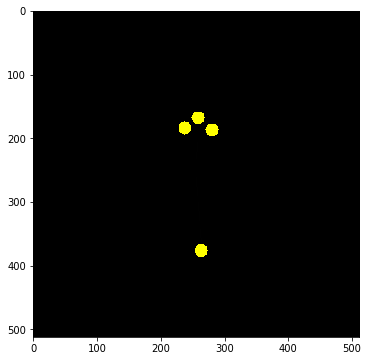

In [495]:
testskel = 1*np.array(skeleton,np.uint8)
color = cv2.cvtColor(testskel,cv2.COLOR_GRAY2BGR)
for j in range(testskel.shape[0]):
    for i in range(testskel.shape[1]):
        if testskel[j][i] == 1 and getCN(testskel,i,j) != 2:
            print("found",i,j,getCN(testskel,i,j),get8n(testskel,i,j))
            cv2.circle(color,(i,j),10,(255,255,0),-1)
# plt.imshow(testskel)
plt.imshow(color)

# 分岐がある場合、もっとも長いセグメントのみを対象とする


In [430]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import math
import pandas as pd
import os

# この関数は画像の入った複数のフォルダが１つのフォルダに入っていることを前提としている。
#  指定フォルダ直下の画像ファイルは無視する。直下のフォルダの中しか見ず、さらにサブフォルダがあっても再帰的に探すようなことはしない。

def listimage(path='シルエット', needThum=False):

    directory = os.listdir(path)
    
    # まずフォルダを全部リストアップ　→ folders
    folders = []
    for x in os.listdir(path):  
        if os.path.isdir(path + '/'+x) and x[0] != '.' and x[0] !='_':  #パスに取り出したオブジェクトを足してフルパスに
            folders.append(path + '/'+x)
    # print(folders)

    # folders の各フォルダの中にある jpg ファイルをリストアップ → ffiles
    # ffiles はフォルダごとのリストのリスト
    ffiles = []
    for x in folders:
        files = []
        for f in os.listdir(x):
            entry = x + '/'+f
            if os.path.isfile(entry) and f[-4:]=='.jpg' and f[0] != '.':
                files.append(entry)
        ffiles.append(files)
    
    if needThum: # サムネイルの作成
        i = 0
        for cat in ffiles:
            # print(folders[i])
            sam = Image.new('RGB', (800,600),(0,0,0))
            row = col = 0
            for rad in cat:
                img = Image.open(rad, 'r')
                thumbnail_size = (100, 100)
                img.thumbnail(thumbnail_size)
                sam.paste(img,(col,row))
                col += 100
                if col == 800:
                    col = 0
                    row += 100
                # plt.imshow(sam)
            sam.save('{}THUM.png'.format(folders[i]), 'PNG')
            print("saved {}".format(folders[i]))
            i +=1

    return folders,ffiles

# マージンをつける
def makemargin(img,mr=2):
    h,w = img.shape[:2]
    w2 = mr*w
    h2 = mr*h
    x1 = int((w2-w)/2)
    y1 = int((h2-h)/2)
    img2 = np.zeros((h2,w2),np.uint8)
    img2[y1:y1+h,x1:x1+w] = img
    return img2

# ２枚の画像をサイズを並べた画像を作成する
def mkparaimage(img1,img2):
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    if img1.ndim == 2:
        img11 = np.zeros((h1,w1,3))
        img11[:,:,0]=img11[:,:,1]=img11[:,:,2]=img1
    else:
        img11=img1
    if img2.ndim == 2:
        img22 = np.zeros((h2,w2,3))
        img22[:,:,0]=img22[:,:,1]=img22[:,:,2]=img2
    else:
        img22=img2
    paraimg = 255*np.ones((max(h1,h2),w1+w2+10,3),dtype=np.uint8)
    
    paraimg[0:h1,0:w1,:] = img11
    paraimg[0:h2,w1+10:,:]=img22
    
    return paraimg

# mkparaimage で２枚並べた画像を表示
def imshowpara(img1,img2):
    plotimg(mkparaimage(img1,img2))

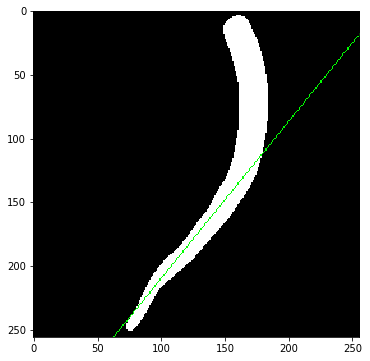

-1

In [221]:
# マージンをつける
def makemargin(img,mr=2):
    h,w = img.shape[:2]
    w2 = mr*w
    h2 = mr*h
    x1 = int((w2-w)/2)
    y1 = int((h2-h)/2)
    img2 = np.zeros((h2,w2),np.uint8)
    img2[y1:y1+h,x1:x1+w] = img
    return img2

img = 255*np.array(skeleton,np.uint8) # スケルトンデータを画像化

# skgray = cv2.resize(skgray,(64,64))　
color = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)

ret,rsskel2 = cv2.threshold(img,1,255,cv2.THRESH_BINARY)
# edges = cv2.Canny(rsskel2,50,150,apertureSize = 3)

lines = cv2.HoughLines(rsskel2,10,np.pi/180,1)

for [rho,theta] in lines[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    dimg = cv2.cvtColor(255*thimg2,cv2.COLOR_GRAY2BGR)
    cv2.line(dimg,(x1,y1),(x2,y2),(0,255,0),1)

img4 = makemargin(thimg2,mr=2) # 作業用のマージンを確保
h3,w3 = thimg2.shape[:2]
h4,w4 = img4.shape[:2]
mat = cv2.getRotationMatrix2D((0,0), -theta, 1.0) # アフィン変換マトリクス

# アフィン変換の適用
outimg = cv2.warpAffine(img4, mat, (0,0))

#plt.imshow(outimg,cmap='cool')
# 結果を出力します

x0,y0 = int(UNIT/2),int(UNIT/2)
x1,y1 = int(2*UNIT-UNIT/2),int(2*UNIT-UNIT/2)
plt.imshow(dimg[y0:y1,x0:x1], cmap='gray')
plt.show()

cv2.imshow("ABC",color)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

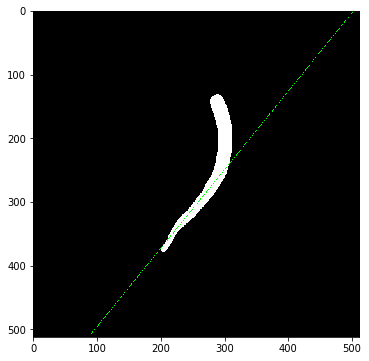

In [75]:
plt.imshow(dimg)

In [76]:
skel,img = step1('概形シルエット2/17Apically/17daruma6o06_l.jpg')

NameError: name 'step1' is not defined

In [77]:
img = step1('概形シルエット2/17Horn/17aomida2o02_l.jpg')

NameError: name 'step1' is not defined

In [ ]:
skel,img = step1('概形シルエット/17Tran_ellip/17karami2o03_l.jpg')

In [ ]:
plt.imshow(img)

**skeleton(img) の結果は画像サイズと同じ配列で、値は True, False である**

予備実験１ここまで

# スケルトンを基にした形状補正

skstat は　[(y,x),距離] のリストである。(x,y) はスケルトン画素の座標

# 距離データ

In [27]:
skstat = max_coverratio(img,skel,32,10,criteria1=1,criteria2=1)

NameError: name 'skel' is not defined

# 距離データを明るさとしてプロットしてみるとこんな感じ

これは重ねて書いただけなので、距離画像ではない。

# スケルトン点列を直線フィッティングしてみる。

In [30]:

# img2 = cv2.imread('概形シルエット/17Tran_ellip/17karami2o03_l.jpg')

skgray = 255*np.array(skeleton,np.uint8)
# rskgray = cv2.resize(skgray,(64,64))
color = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
scolor = cv2.cvtColor(skgray,cv2.COLOR_GRAY2BGR)

# blurimg = cv2.GaussianBlur(rskgray,(33,33),0) 
ret,rsskel2 = cv2.threshold(rskgray,1,255,cv2.THRESH_BINARY)
# edges = cv2.Canny(rsskel2,50,150,apertureSize = 3)

lines = cv2.HoughLines(rsskel2,1,np.pi/180,1)
minLineLength = 10
maxLineGap = 5
# lines = cv2.HoughLinesP(edges,1,np.pi/180,10,minLineLength,maxLineGap)
# for [[x1,y1,x2,y2]] in lines:
for [rho,theta] in lines[0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(scolor,(x1,y1),(x2,y2),(0,255,0),1)
        cv2.line(color,(x1,y1),(x2,y2),(0,255,0),1)
        
        #cv2.line(color,(x1,y1),(x2,y2),(0,0,255),2)
        print((x1,y1),(x2,y2))

mimg = cv2.medianBlur(img,5)
cimg = cv2.cvtColor(mimg,cv2.COLOR_GRAY2BGR)

circles = cv2.HoughCircles(mimg,cv2.HOUGH_GRADIENT,1,30,
# circles = cv2.HoughCircles(rsskel2,cv2.HOUGH_GRADIENT,1,30,
                            param1=20,param2=10,minRadius=5,maxRadius=0)

circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),1)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),1,(0,0,255),1)
        
plt.subplot(131), plt.imshow(scolor)
plt.title("64x64 image")
plt.subplot(132), plt.imshow(color)
plt.title("line")
plt.subplot(133), plt.imshow(cimg)
plt.title("circle")

'''cv2.imshow("ABC",color)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)'''

error: OpenCV(3.4.2) /opt/concourse/worker/volumes/live/9523d527-1b9e-48e0-7ed0-a36adde286f0/volume/opencv-suite_1535558719691/work/modules/imgproc/src/color.hpp:253: error: (-215:Assertion failed) VScn::contains(scn) && VDcn::contains(dcn) && VDepth::contains(depth) in function 'CvtHelper'


In [31]:
import sys
import tensorflow as tf

x_data = np.array([x for [(y,x),d] in skstat]).astype(np.float32)
y_data = np.array([y for [(y,x),d] in skstat]).astype(np.float32)
w_data = np.array([d for [(y,x),d] in skstat]).astype(np.float32)

NameError: name 'skstat' is not defined

In [ ]:
circles

In [ ]:
y_data

In [ ]:
 = [[1.],[5.]]
input_y = [[4.],[2.]]

x = tf.placeholder("float", [None, 1])
y_ = tf.placeholder("float", [None, 1])

a = tf.Variable([1.], name="slope")
b = tf.Variable([0.], name="y-intercept")
y = tf.multiply(a, x) + b

init = tf.global_variables_initializer()

# 誤差関数
loss = tf.reduce_sum(tf.square(y_ - y))

# トレーニング方法は、勾配降下法を選択
train_step = tf.train.GradientDescentOptimizer(0.03).minimize(loss)


with tf.Session() as sess:
    sess.run(init)
    print('初期状態')
    print('誤差' + str(sess.run(loss, feed_dict={x_: input_x, y_: input_y, w_:input})))
    print("slope: %f, y-intercept: %f" % (sess.run(a), sess.run(b)))

    for step in range(100):
        sess.run(train_step, feed_dict={x: input_x, y_: input_y})
        if (step+1) % 20 == 0:
            print('\nStep: %s' % (step+1))
            print('誤差' + str(sess.run(loss, feed_dict={x: input_x, y_: input_y})))
            print("slope: %f, y-intercept: %f" % (sess.run(a), sess.run(b)))
#
sys.stderr.write("*** end ***\n")

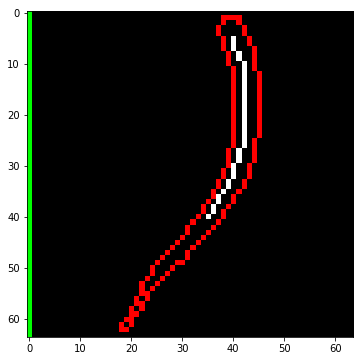

In [32]:
skeleton.shape
plt.imshow(img)

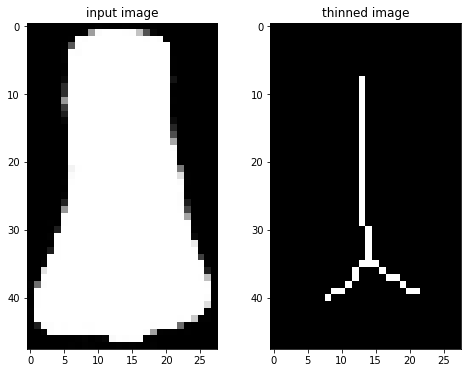

In [33]:
from skimage.morphology import skeletonize, skeletonize_3d
import matplotlib.pyplot as plt
from skimage.util import invert
from skimage import io
import skimage.data
import skimage.color
import os

img = cv2.imread('概形シルエット/17Apically/17daruma6o06_l.jpg',0)
img = cv2.resize(img,(int(img.shape[1]/5),int(img.shape[0]/5)))
ret,th2 = cv2.threshold(img,127,1,cv2.THRESH_BINARY)

skeleton = skeletonize(th2)
# 結果を出力します
plt.subplot(121), plt.imshow(img, cmap='gray')
plt.title("input image")
plt.subplot(122), plt.imshow(skeleton, cmap='gray')
plt.title("thinned image")
plt.show()

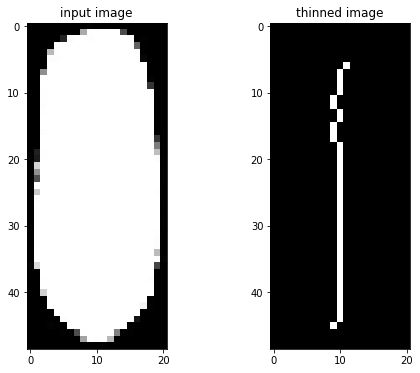

In [34]:
img = cv2.imread('概形シルエット/17Cylindric/17makoto1o06_l.jpg',0)
img = cv2.resize(img,(int(img.shape[1]/5),int(img.shape[0]/5)))
ret,th2 = cv2.threshold(img,127,1,cv2.THRESH_BINARY)

skeleton = skeletonize(th2)
# 結果を出力します
plt.subplot(121), plt.imshow(img, cmap='gray')
plt.title("input image")
plt.subplot(122), plt.imshow(skeleton, cmap='gray')
plt.title("thinned image")
plt.show()

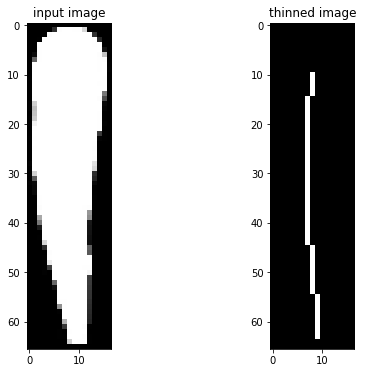

In [35]:
img = cv2.imread('概形シルエット/17Triagular/17horyou1o05_l.jpg',0)
img = cv2.resize(img,(int(img.shape[1]/5),int(img.shape[0]/5)))
ret,th2 = cv2.threshold(img,127,1,cv2.THRESH_BINARY)

skeleton = skeletonize(th2)
# 結果を出力します
plt.subplot(121), plt.imshow(img, cmap='gray')
plt.title("input image")
plt.subplot(122), plt.imshow(skeleton, cmap='gray')
plt.title("thinned image")
plt.show()

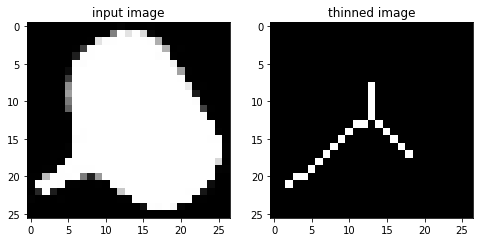

In [36]:
img  = cv2.imread('概形シルエット/17Tran_ellip/17karami2o03_l.jpg',0)
img = cv2.resize(img,(int(img.shape[1]/5),int(img.shape[0]/5)))
ret,th2 = cv2.threshold(img,127,1,cv2.THRESH_BINARY)

skeleton = skeletonize(th2)
# 結果を出力します
plt.subplot(121), plt.imshow(img, cmap='gray')
plt.title("input image")
plt.subplot(122), plt.imshow(skeleton, cmap='gray')
plt.title("thinned image")
plt.show()

In [37]:
# メインプログラム
from skimage.morphology import skeletonize, skeletonize_3d
import matplotlib.pyplot as plt
from skimage.util import invert
from skimage import io
import skimage.data
import skimage.color
import os

def batch(images, savedir='スケルトン',normalize=False,interactive = True):
    # savedir 保存先
    # interactive 結果を１枚ずつ確認するかどうか
    global skeleton,img,wimg
    
    for path in images:
        # print(path)
        
        src = cv2.imread(path,0) # 対象画像の読み込み
        
        if normalize:
            # 処理対象画像を　短辺６４に正規化する
            height, width = src.shape[:2]
            nlen = width if width < height else height # 縦横の短い方
            shrink = 64/nlen # 縮小率
            src = cv2.resize(src,(int(shrink*width),int(shrink*height)))
        
        # ２値化するとともに、白を１にする
        _ret,img = cv2.threshold(src,127,1,cv2.THRESH_BINARY)
        
        # scikit-learn の高速細線化処理を適用
        skeleton = np.array(255*skeletonize(img),dtype=np.uint8)
        
        # 端点を抽出
        _img,cnt,hierarchy = cv2.findContours(skeleton, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        wimg = np.zeros(img.shape,np.uint8)
        wimg = cv2.drawContours(wimg, [cnt[0]], -1, 255, 1)
        print(set(tuple(cnt[0])))
                                

        # 結果を確認       
        if interactive:
            cv2.imshow(path,mkparaimage(cv2.bitwise_xor(src,img),skeleton))
            key = cv2.waitKey(0)
            cv2.destroyAllWindows()
            cv2.waitKey(1) 
            if key == 113: #  "Q" で終了する
                break
                
def neighbours(x, y, image):
    return [image[x-1][y], image[x-1][y+1], image[x][y+1], image[x+1][y+1], 
             image[x+1][y], image[x+1][y-1], image[x][y-1], image[x-1][y-1]]

def isterminal(x,y,image):
    return sum(neighbours(x,y,image))

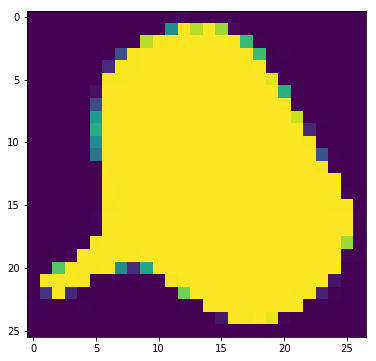

In [38]:
plt.imshow(img)
wimg = np.copy(img)

In [39]:
sskel=255*skel.astype(np.uint8)
cv2.imshow("AB C",edges)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

NameError: name 'skel' is not defined

In [40]:
import cv2
import numpy as np

# img2 = cv2.imread('概形シルエット/17Tran_ellip/17karami2o03_l.jpg')

skgray = 255*np.array(skeleton,np.uint8)
# rskgray = cv2.resize(skgray,(64,64))
color = cv2.cvtColor(skgray,cv2.COLOR_GRAY2BGR)
# blurimg = cv2.GaussianBlur(rskgray,(33,33),0) 
ret,rsskel2 = cv2.threshold(rskgray,1,255,cv2.THRESH_BINARY)
# edges = cv2.Canny(rsskel2,50,150,apertureSize = 3)

lines = cv2.HoughLines(rsskel2,1,np.pi/180,1)
minLineLength = 10
maxLineGap = 5
# lines = cv2.HoughLinesP(edges,1,np.pi/180,10,minLineLength,maxLineGap)
# for [[x1,y1,x2,y2]] in lines:
for [rho,theta] in lines[0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(color,(x1,y1),(x2,y2),(0,255,0),2)
        
        # cv2.line(color,(x1,y1),(x2,y2),(0,0,255),2)
        print((x1,y1),(x2,y2))

cv2.imshow("ABC",color)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

NameError: name 'rskgray' is not defined

In [41]:
lines[0]

array([[0., 0.]], dtype=float32)